In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from scipy.ndimage import gaussian_filter1d
from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
import quantities as pq
from quantities import Hz, s, ms

In [2]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

def bin_time_series(array, binsize, gaussian = True, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    gauss_array = np.zeros((n,totalsize))
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
    else:gauss_array = array
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
    return(A)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def jitter(spike, k):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-k,k)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

def spike_count(spikes, num_bins, ax, spy = True, t_min = None, t_max = None):
    n,t = spikes.shape
    if t_min is None: t_min = 0
    if t_max is None: t_max = t
    if t_max<=t_min: raise ValueError('t_min should be less than t_max')
    spike_count = []
    for i in range(n):
        spike_count.append(np.sum(spikes[i][t_min:t_max]))
    n, bins, patches = plt.hist(spike_count, num_bins, facecolor='blue', alpha=0.5)
    if spy: plt.show()
    return(n,bins)

# Describe a community expansion

In [3]:
num_comms = 1 # number ofcommunities to expand
spike_rate = 10 # spike rate per commiunity
comm_size = [30,20,20,10,10,5,5,5,5,10]
num_neurons = int(sum(comm_size))
bin_size = 1000.0 # in frames, in every bin_size, a community activity occurs
seconds = len(comm_size)
total_duration = int(seconds*bin_size)
window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
layers = int(total_duration/window_size)

In [4]:
spikes = np.zeros((num_neurons,total_duration))
master_spike = np.zeros((1,total_duration))
master = homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = total_duration*ms, as_array=True) 

for i,e in enumerate(master):    
    master_spike[0][int(e)] = 1
for i in range(comm_size[0]):
    spikes[i] = jitter(master_spike, 5)

comms = []
for i in range(1,len(comm_size)):
    comms.append([homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = i*bin_size*ms, as_array=True) for j in range(comm_size[i])])

neuron_count = comm_size[0]
for i,e in enumerate(comms):## this is for 
    for j,f in enumerate(e):
        for k,m in enumerate(f):
            spikes[neuron_count+j][int(m)] = 1
    neuron_count = neuron_count + len(e)
            
neuron_count = comm_size[0]
for i in range(1,len(comms)+1):
    for j in range(neuron_count,neuron_count+comm_size[i]):
        for k in np.nonzero(spikes[0][(i*1000):])[0]:
            jitt = random.randint(-5,5)
            try:spikes[j,(i*1000)+k+jitt] = 1
            except:spikes[j,k] = 1
    neuron_count = neuron_count + comm_size[i]

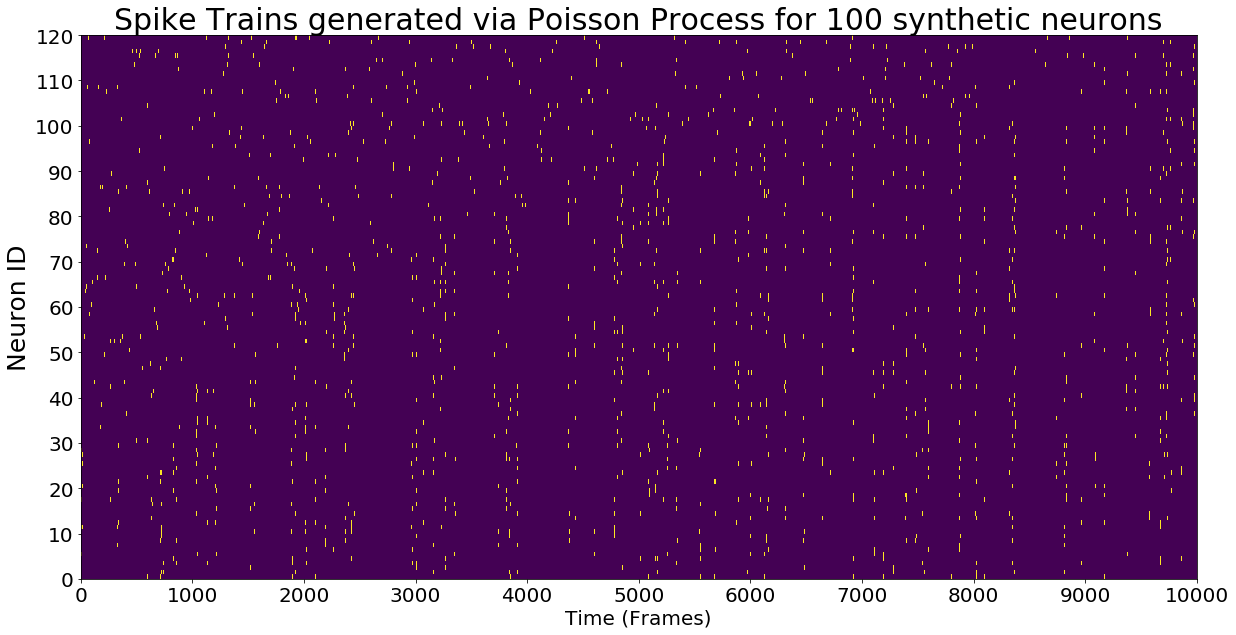

In [5]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(spikes, origin = 'lower', interpolation='nearest', aspect='auto',  extent = [0,10000,0,120])
ax.set_title('Spike Trains generated via Poisson Process for 100 synthetic neurons', fontsize= 30)
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)
ax.set_xticks([j*1000 for j in range(11)])
ax.set_yticks([i*10 for i in range(13)])
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.set_xlabel('Time (Frames)', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
#plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/spiketrain_synthetic.pdf')

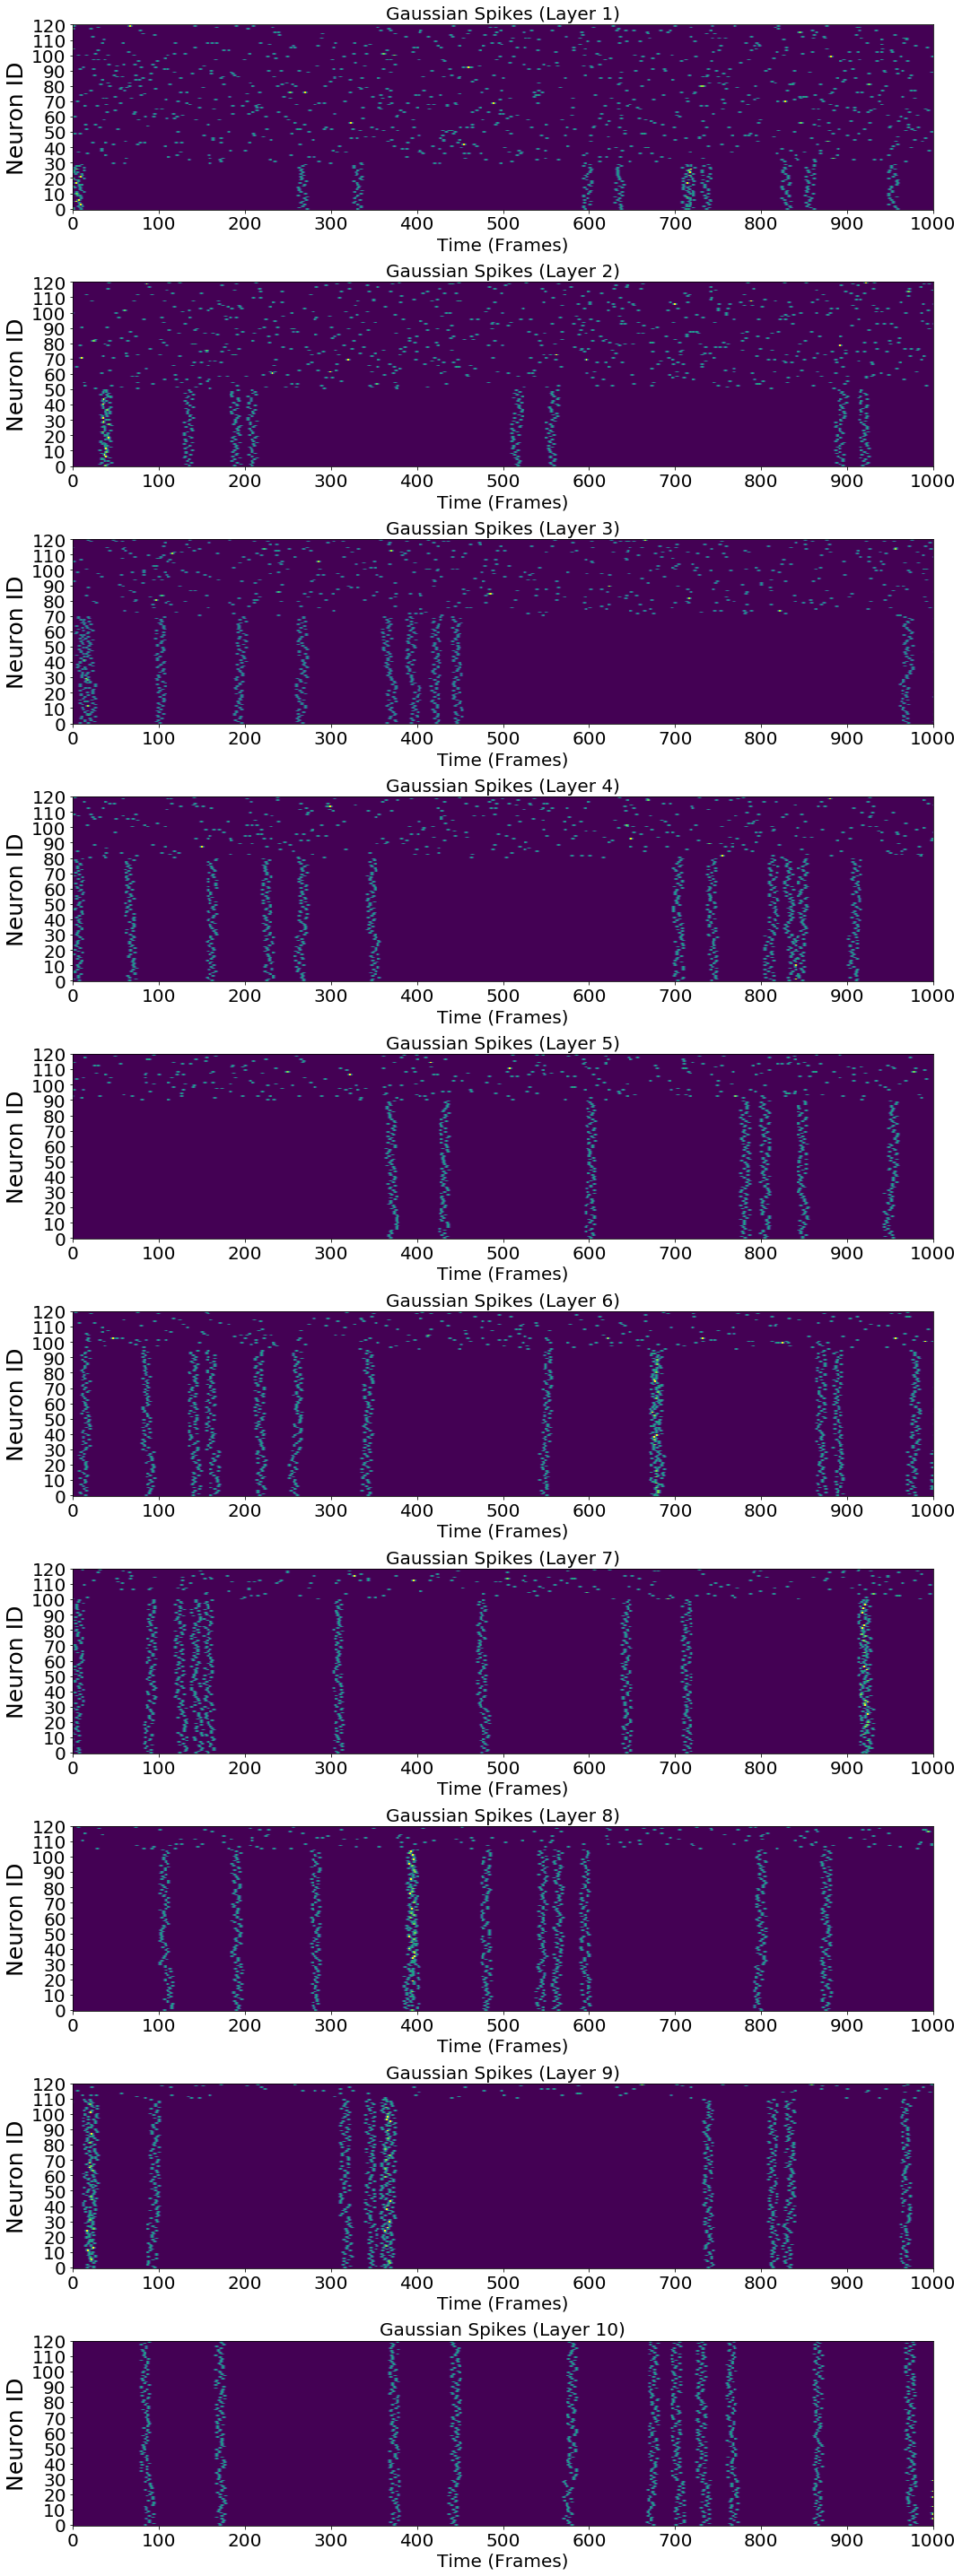

In [6]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers,1,figsize=(15,40))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto')
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(13)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()
#plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/binned_spiketrain_synthetic.pdf')

In [8]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


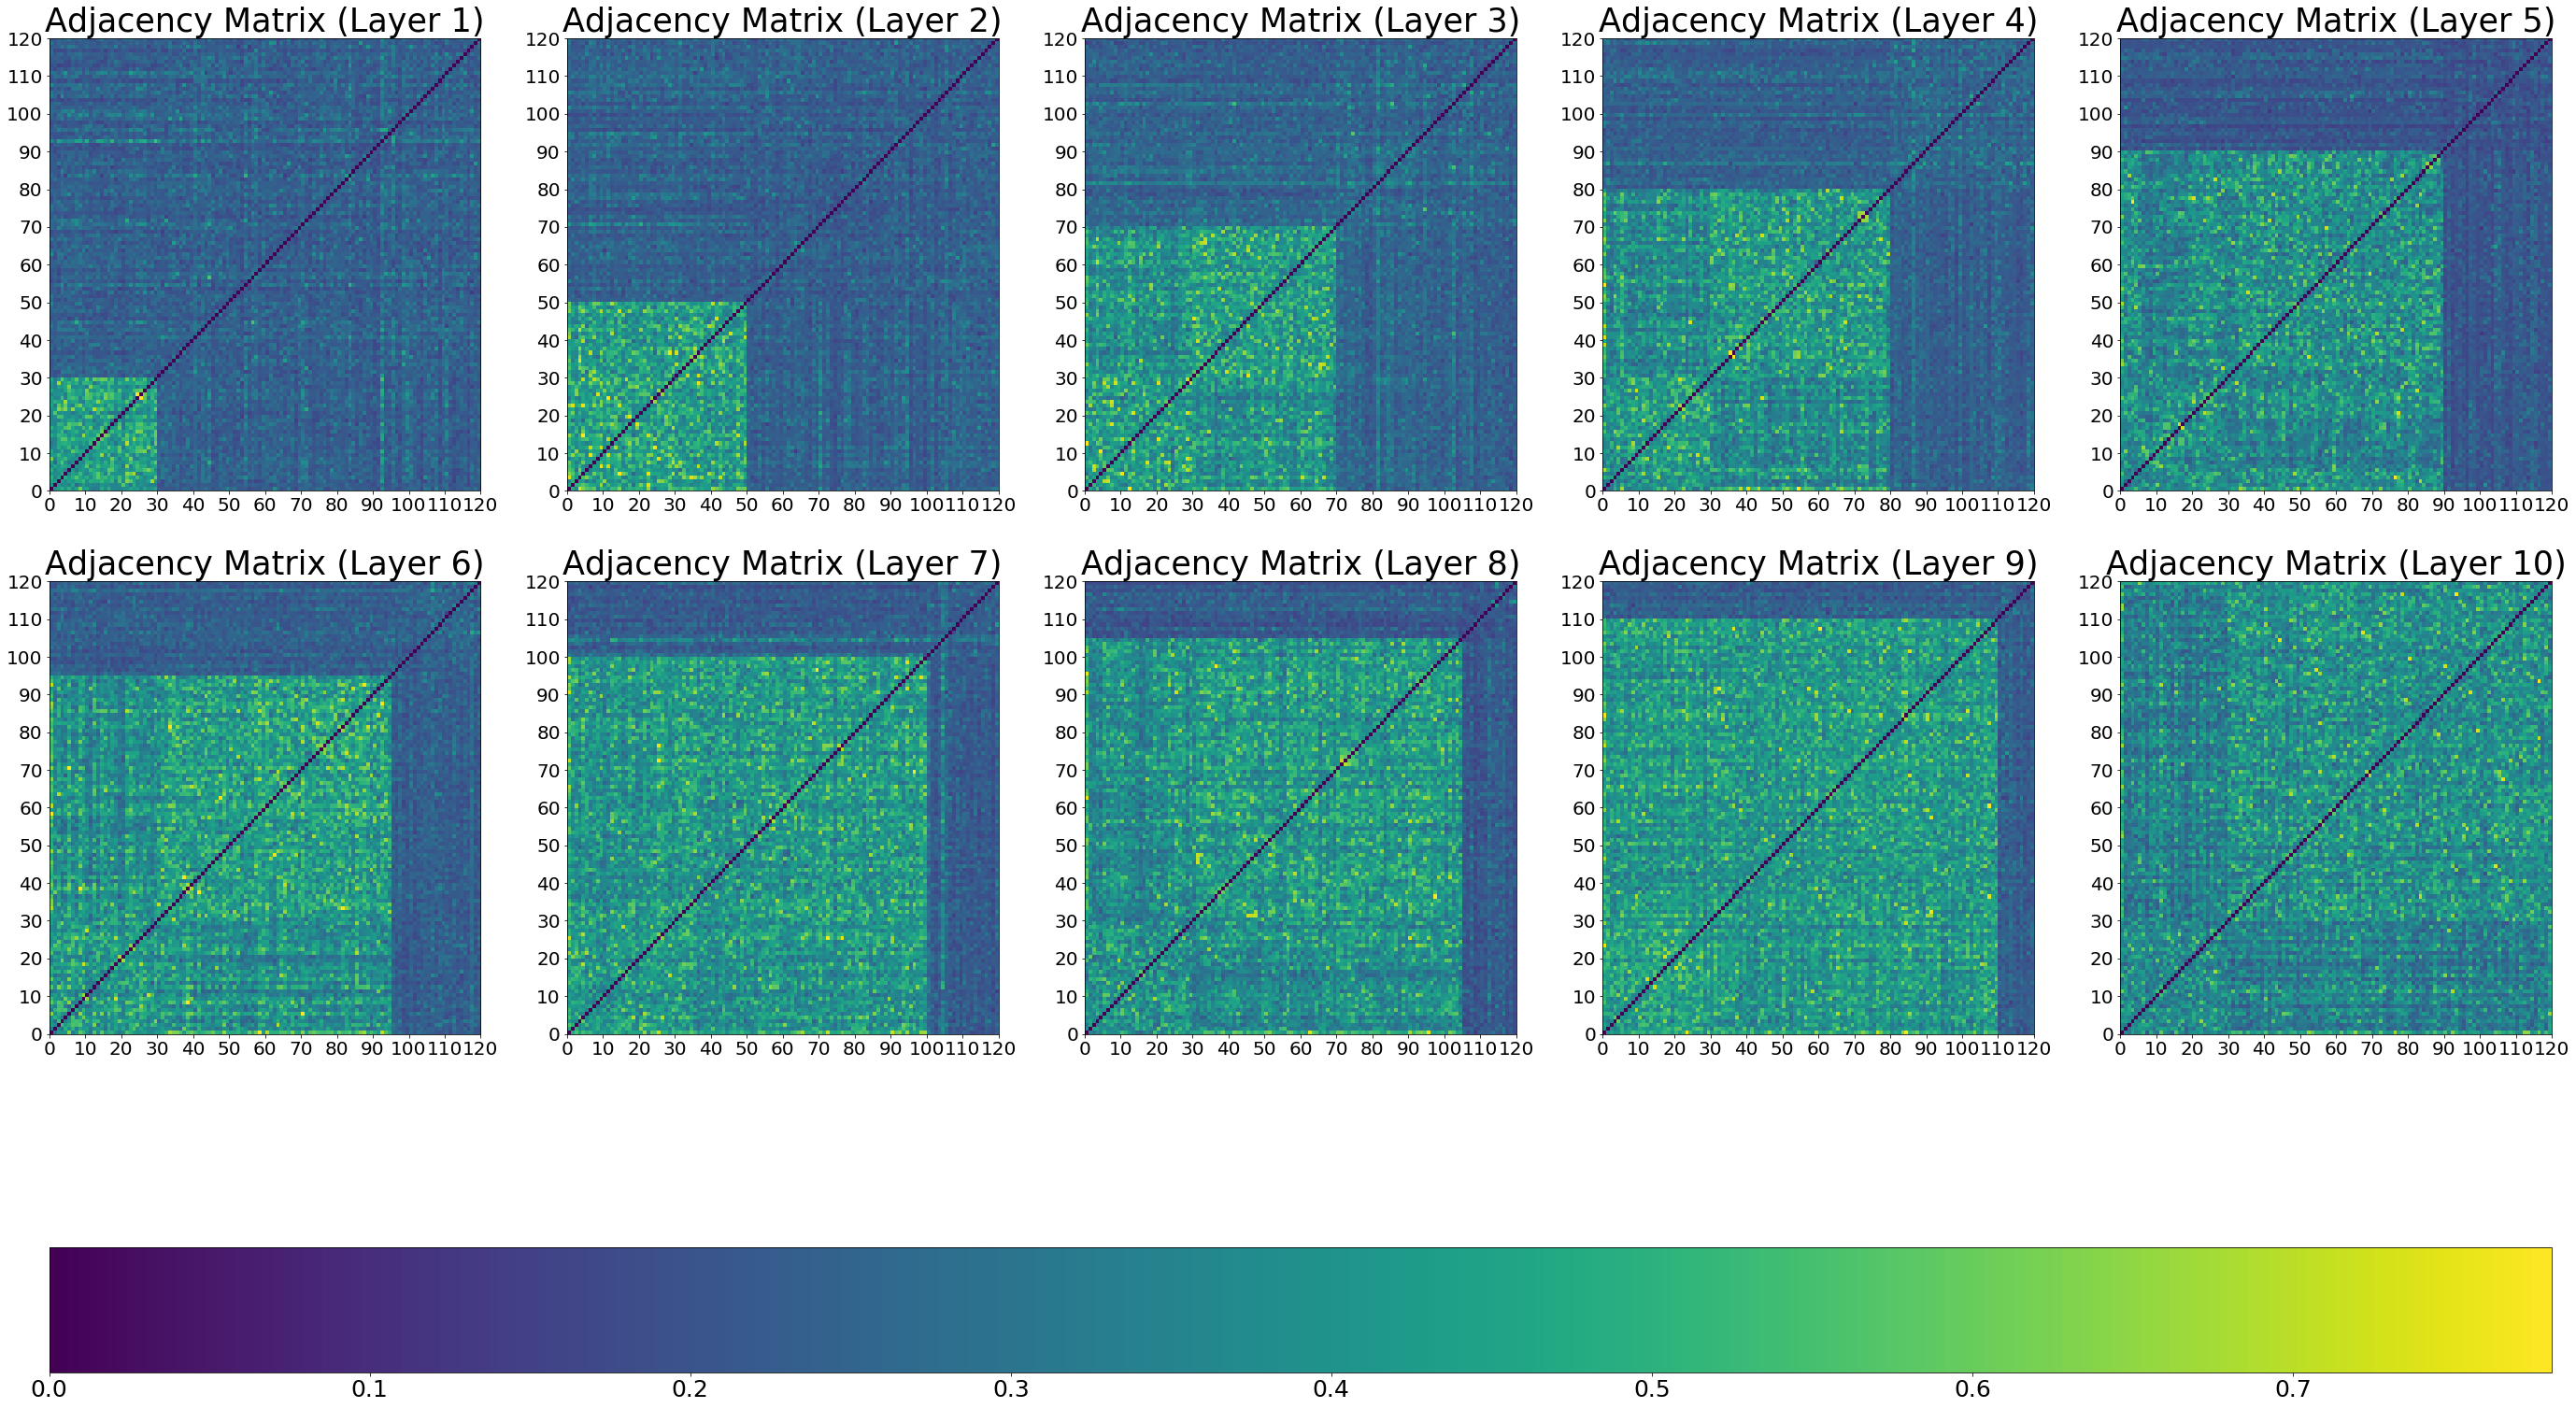

In [19]:
fig,ax = plt.subplots(2, 5, figsize = (48,28))
for i in range(2):
    for j in range(5):
        k = ax[i][j].imshow(adjacency_matrices[i*5+j], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,120,0,120])
        ax[i][j].set_title('Adjacency Matrix (Layer %d)'%(i*5+j +1), fontsize = 35)
        ax[i][j].set_xticks([k*10 for k in range(13)])
        ax[i][j].set_yticks([k*10 for k in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 20)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 
#plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/adjacency.pdf')